In [1]:
# Import the relevant libraries.
import AbstractMCMC
using Distributions
using Random

In [2]:
# Define a sampler type.
struct MetropolisHastings{T, D} <: AbstractMCMC.AbstractSampler 
    init_θ::T
    proposal::D
end

# Default constructors.
MetropolisHastings(init_θ::Real) = MetropolisHastings(init_θ, Normal(0,1))
#proposal distribution is a 2 dimensional normal distribution with zero mean vectors and standard diagnoal sigma matrix
MetropolisHastings(init_θ::Vector{<:Real}) = MetropolisHastings(init_θ, MvNormal(length(init_θ),1))

MetropolisHastings

In [3]:
# Define a model type. Stores the log density function.
struct DensityModel{F<:Function} <: AbstractMCMC.AbstractModel
    ℓπ::F
end

In [4]:
# Create a very basic Transition type, only stores the 
# parameter draws and the log probability of the draw.
#θ is drawed sample and lp is log_pdf with current θ
struct state{T, L}
    θ::T
    lp::L
end

# Store the new draw and its log density.
state(model::DensityModel, θ) = state(θ, ℓπ(model, θ))

state

In [5]:
# Define the first step! function, which is called at the 
# beginning of sampling. Return the initial parameter used
# to define the sampler.
function AbstractMCMC.step(
    rng::AbstractRNG,
    model::DensityModel,
    spl::MetropolisHastings;
    kwargs...
)
    return spl.init_θ,state(model, spl.init_θ)
end

In [27]:
propose(spl, model, [0,0])

state{Array{Float64,1},Float64}([1.065804078405824, -0.8201889117946909], -Inf)

In [6]:
# Define a function that makes a basic proposal depending on a univariate
# parameterization or a multivariate parameterization.
propose(spl::MetropolisHastings, model::DensityModel, θ::Real) = 
    state(model, θ + rand(spl.proposal))
propose(spl::MetropolisHastings, model::DensityModel, θ::Vector{<:Real}) = 
    state(model, θ + rand(spl.proposal))
propose(spl::MetropolisHastings, model::DensityModel, t::state) =
    propose(spl, model, t.θ)

# Calculates the probability `q(θ|θcond)`, using the proposal distribution `spl.proposal`.
q(spl::MetropolisHastings, θ::Real, θcond::Real) = logpdf(spl.proposal, θ - θcond)
q(spl::MetropolisHastings, θ::Vector{<:Real}, θcond::Vector{<:Real}) =
    logpdf(spl.proposal, θ - θcond)
q(spl::MetropolisHastings, t1::state, t2::state) = q(spl, t1.θ, t2.θ)

# Calculate the density of the model given some parameterization.
ℓπ(model::DensityModel, θ) = model.ℓπ(θ)
ℓπ(model::DensityModel, t::state) = t.lp

# Define the other step function. Returns a Transition containing
# either a new proposal (if accepted) or the previous proposal 
# (if not accepted).
function AbstractMCMC.step(
    rng::AbstractRNG,
    model::DensityModel,
    spl::MetropolisHastings,
    θ_prev::state;
    kwargs...
)
    # Generate a new proposal.
    θ = propose(spl, model, θ_prev)

    # Calculate the log acceptance probability.
    α = ℓπ(model, θ) - ℓπ(model, θ_prev) + q(spl, θ_prev, θ) - q(spl, θ, θ_prev)

    # Decide whether to return the previous θ or the new one.
    if log(rand(rng)) < min(α, 0.0)
        return θ.θ, θ
    else
        return θ_prev.θ, θ
    end
end

In [7]:
# Generate a set of data from the posterior we want to estimate.
data = rand(Normal(5, 3), 30)

# Define the components of a basic model.
insupport(θ) = θ[2] >= 0
dist(θ) = Normal(θ[1], θ[2])
density(θ) = insupport(θ) ? sum(logpdf.(dist(θ), data)) : -Inf

# Construct a DensityModel.
model = DensityModel(density)

# Set up our sampler with initial parameters.
spl = MetropolisHastings([0.0, 0.0])

# Sample from the posterior.
chain = sample(model, spl, 100000; param_names=["μ", "σ"])

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


100000-element Array{Array{Float64,1},1}:
 [0.0, 0.0]
 [0.0, 0.0]
 [-2.0688362283876724, 0.1301408669655263]
 [-1.7254744750752058, 0.42062441481222657]
 [-1.7254744750752058, 0.42062441481222657]
 [-1.0763613310329025, -0.9558160075100121]
 [-3.2176652577515648, 2.6274241782324976]
 [-3.2176652577515648, 2.6274241782324976]
 [-4.536814079825007, 3.69484444756666]
 [-3.7998896094098797, 3.543843996728193]
 [-3.0973352356880897, 3.751562654221262]
 [-3.0228119804362508, 3.7963462645751265]
 [-3.0228119804362508, 3.7963462645751265]
 ⋮
 [291.59383535158656, -158.20326864506967]
 [291.1285259677443, -159.19310545211295]
 [289.44445448117585, -158.87603875229087]
 [289.3727590961778, -160.04103150487924]
 [288.4400151488637, -159.75171482131978]
 [287.41540561733746, -158.32167852680635]
 [286.5381043239382, -157.44311713495446]
 [286.3761675236892, -156.06699882907856]
 [286.8835825264225, -155.39986016014052]
 [287.09213035481184, -154.96086966095496]
 [287.1083448104134, -154.0537881872

In [49]:
chain[1:9999]

2-element Array{Float64,1}:
 -1.2712077598998297
  0.2660737148897161

In [71]:
a = chain[788]
a[1]

-39.602530147511345

In [79]:
x = zeros(0)
for i in 1:10000
    tmp = chain[i]
    append!(x,tmp[1])
end


In [82]:
mean(x)

-40.12299930417242

In [1]:
plot(x)

LoadError: [91mUndefVarError: plot not defined[39m

In [23]:
# Generate a set of data from the posterior we want to estimate.
data = rand(Normal(5, 3), 30)

# Define the components of a basic model.
insupport(θ) = θ[2] >= 0
dist(θ) = Normal(θ[1], θ[2])
density(θ) = insupport(θ) ? sum(logpdf.(dist(θ), data)) : -Inf

# Construct a DensityModel.
model = DensityModel(density)

# Set up our sampler with initial parameters.
spl = MetropolisHastings([0.0, 0.0])
chain = sample(model, spl, 100000; param_names=["μ", "σ"])

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


100000-element Array{Array{Float64,1},1}:
 [0.0, 0.0]
 [-1.2712077598998297, 0.2660737148897161]
 [-0.47149956236741397, 2.257357874443663]
 [-0.47149956236741397, 2.257357874443663]
 [-0.27744400858669027, 2.0148728916859246]
 [-0.4587200677971412, 2.0979466910629645]
 [2.0678799952641373, 1.8743915145089731]
 [1.6537160699363926, 2.1182390765241954]
 [1.6537160699363926, 2.1182390765241954]
 [0.8638288338538342, 2.0499587120525944]
 [0.4208458600680194, 2.199204590546542]
 [1.2739444195309786, 2.4728935863307506]
 [1.2739444195309786, 2.4728935863307506]
 ⋮
 [-559.5828599151316, -315.88792586340645]
 [-558.9212403324103, -316.7817461080237]
 [-559.3459794936329, -317.5622338165631]
 [-559.9226267847026, -318.543184321268]
 [-560.8842967604205, -316.99201431961023]
 [-561.2786630019043, -316.8304591120789]
 [-560.1056816807453, -318.75926460261724]
 [-559.0955153594798, -318.18190402739197]
 [-559.7642357867943, -317.11810087614094]
 [-559.3307341962866, -317.99023437810195]
 [-559.22

In [24]:
mean(chain)

2-element Array{Float64,1}:
 -425.56416500704364
  -46.40472930093787

In [34]:
using MCMCChains
using StatsPlots


LoadError: [91msyntax: invalid identifier name "?"[39m

In [35]:
using Turing
using StatsPlots

# Define a simple Normal model with unknown mean and variance.
@model function gdemo(x, y)
  s ~ InverseGamma(2, 3)
  m ~ Normal(0, sqrt(s))
  x ~ Normal(m, sqrt(s))
  y ~ Normal(m, sqrt(s))
end

#  Run sampler, collect results
chn = sample(gdemo(1.5, 2), HMC(0.1, 5), 1000)

# Summarise results
describe(chn)

# Plot and save results

2-element Array{ChainDataFrame,1}:
 Summary Statistics (2 x 7)
 Quantiles (2 x 6)

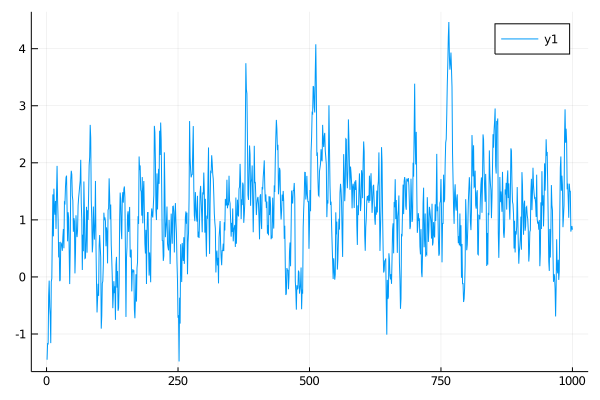

In [38]:
plot(chn[:m])